# Robotic Navigation Toy Problem
This notebook imports a map image (created by ppt) and converts it to a graph.     
The nodes are the coordinate of accessible positions in the map and the edges are discrete actions (up, down, left and right).    
The first part demonstrates how a shortest path search in the networkx package scales on the grid size. 

In [274]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [275]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML
import time

In [276]:
from networkx.algorithms.shortest_paths.generic import shortest_path

def maxpool(img, window_size=50):
    newrows = img.shape[0]//window_size+1
    newcols = img.shape[1]//window_size+1
    newimg = np.zeros((newrows,newcols))
    for row in range(newrows):
        for col in range(newcols):
            newimg[row,col] = np.max(img[row*window_size:(row+1)*window_size,col*window_size:(col+1)*window_size])
    return newimg      

def coarse_map(map_orig, poolsize=5):
    return np.concatenate([np.expand_dims(maxpool(map_orig[:,:,0],poolsize),-1),np.expand_dims(maxpool(map_orig[:,:,1],poolsize),-1),np.expand_dims(maxpool(map_orig[:,:,2],poolsize),-1)],axis=-1)

def extract_edges(node_coords):
    edges=[]
    for i in range(1,node_coords[:,0].max()+1): #row sweep
        indexes=np.argwhere(node_coords[:,0]==i).T[0] 
        for k in range(1,len(indexes)):
            if abs(node_coords[indexes[k],1]-node_coords[indexes[k-1],1])==1:
                edges.append((indexes[k-1],indexes[k]))
    for j in range(1,node_coords[:,1].max()+1): #col sweep
        indexes=np.argwhere(node_coords[:,1]==j).T[0]       
        for k in range(1,len(indexes)):
            if abs(node_coords[indexes[k],0]-node_coords[indexes[k-1],0])==1:
                edges.append((indexes[k-1],indexes[k]))
    return edges   

def find_index(lst,val):
    for i in range(len(lst)):
        el=lst[i]           
        if (abs(el[0]-val[0])<=1)&(abs(el[1]-val[1])<=1):
            return i
            

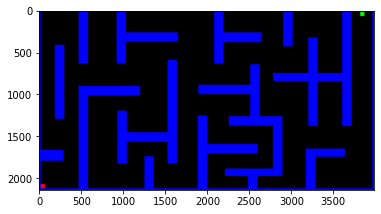

In [277]:
maze = plt.imread('maps/map1.jpg')
# create start and goal regions. It is manually created after inspecting the map
maze[2064:2114,21:71,1] = 1 #start region
maze[21:71, 3825:3875, 2] = 1 #goal
plt.imshow(maze[:,:,1:]) 

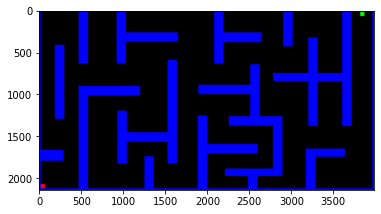

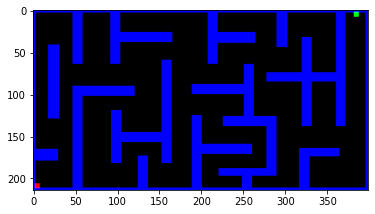

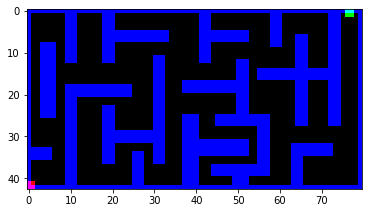

In [278]:
# The image from ppt has 4 channels, so I had to choose 3 channels for the start region, goal region, and the walls (mz0 below)
# The start and goal regions were manually selected after visual inspection of the map, and they are more than 1 pixels for visualization purposes. 
# If we use a different maze generating tool, perhaps different preprocessing may be needed.
# Below shows the resulting maps when we coarsen the original grid (2136 x 3989) by subsampling by 10 and 50 pixels in each row and cols.
mz0=maze[:,:,1:]
mz10 = coarse_map(mz0,10)
mz50 = coarse_map(mz0,50)
plt.imshow(mz0)
plt.show()
plt.imshow(mz10)
plt.show()
plt.imshow(mz50)
plt.show()

In [279]:
def calc_shortest_path(grid):
    node_coords = np.argwhere(1-grid[:,:,2])
    print(len(node_coords), 'nodes.')
    ##  extract edges
    t0=time.perf_counter()
    edges = extract_edges(node_coords)
    t1=time.perf_counter()
    print(len(edges), 'edges extracted', t1-t0, 's.')
    t0=time.perf_counter()
    G=nx.Graph()
    G.add_nodes_from(range(len(node_coords)))
    G.add_edges_from(edges)
    t1=time.perf_counter()
    print('Graph created', t1-t0, 's.') 
    source = find_index(node_coords,np.argwhere(grid[:,:,0]*(1-grid[:,:,2]))[0]) # since source and target node need to be unique, it chooses one node out of the region
    target = find_index(node_coords,np.argwhere(grid[:,:,1]*(1-grid[:,:,2]))[0])
    print('source', source,'target', target)
    t0=time.perf_counter()
    sp = shortest_path(G,source,target)
    t1=time.perf_counter()
    print('Shortest path with length', len(sp), t1-t0,'s.')
    return sp, G

In [456]:
sp50, G50 = calc_shortest_path(mz50)

2081 nodes.
3681 edges extracted 0.010987534999003401 s.
Graph created 0.009960243998648366 s.
source 1959 target 59
Shortest path with length 154 0.0027019290027965326 s.


In [281]:
import copy
def display(grid,sp):
    node_coords = np.argwhere(1-grid[:,:,2])
    overlay = copy.deepcopy(grid)
    for i in sp:
        x = node_coords[i]
        overlay[x[0],x[1],0]=1
        overlay[x[0],x[1],1]=1
    plt.imshow(overlay) 

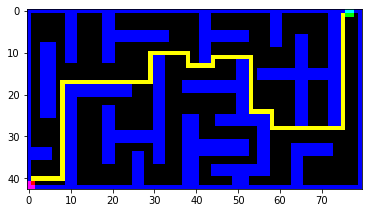

In [282]:
display(mz50,sp50)

60845 nodes.
119303 edges extracted 0.26786221000111254 s.
Graph created 0.5460548150003888 s.
source 58847 target 318
Shortest path with length 743 0.07520462600041355 s.


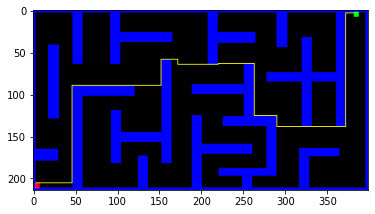

In [283]:
sp10, G10 = calc_shortest_path(mz10)
display(mz10,sp10)

6310323 nodes.
12596752 edges extracted 67.86560907199964 s.
Graph created 120.57361817499987 s.
source 6134355 target 3243
Shortest path with length 7418 12.531795898999917 s.


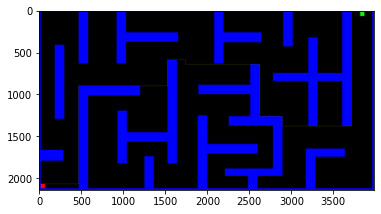

In [284]:
sp0, G0 = calc_shortest_path(mz0)
display(mz0,sp0) 

In [285]:
print(mz0.shape)
print(mz10.shape)
print(mz50.shape)

(2136, 3989, 3)
(214, 399, 3)
(43, 80, 3)


## Conclusion
In this experiment, I showed how time scales on coarsened grids.

|Coarsening|None|10|50|
|:-------:|:---------------:|:----------:|:---------:|
| grid size|2136x3989 | 214x399|43x80|
|num nodes|6.3M|61k|2k|
|num edges|12.6M|119k|3.7k|
|time edge created| 51s | 0.17s|0.015s|
|time graph created| 64s | 0.5 s|0.013s|
|time shortest path| 12.5s|0.08s|0.003s|
|shortest path length|7418|743|154|

Shortest path calculation on a grid with 12M edges didn't take long.    
It seems that there is not much advantage of using GNN to calculate shortest path on this 10M edge sized map.    
Perhaps if it becomes 3D or bigger action space, it's more useful to coarsen.    
Also it assumes grids are known and accurate. In real world, grid may be estimated from measurements.    
But to do that an agent need to explore all area and accurately map the walls and objects.    
Also when there is a moving object (or its location changes occasionally), then, the agent needs to do the mapping and searching again. (well, is it different when we use GNN?)    
Perhaps in a dynamically changing environment, it is better to have a short-term plan. Such as identify turn or corner, then go there then look around.  

For project purpose, we prioritize two tasks: graph abstraction (supergraph generation) and node feature calculation to make the agent move along the middle part of the corridor (not getting too close to the wall).  

# Edge Augmentation

In [442]:
def random_walk(G, start_node, walk_length):
    walk = [start_node]
    
    for i in range(walk_length):
        all_neighbours = [n for n in G.neighbors(start_node)]
        next_node = np.random.choice(all_neighbours, 1)[0]
        walk.append(next_node)
        start_node = next_node
    
    return walk

In [443]:
[n for n in G50.neighbors(5)]

[4, 6, 68]

In [542]:
node_coords = np.argwhere(1-mz50[:,:,2])

In [445]:
walk = random_walk(G50, 5, 10)
print('Steps in random walk:', len(walk), walk)

Steps in random walk: 11 [5, 6, 7, 70, 7, 70, 133, 132, 133, 132, 195]


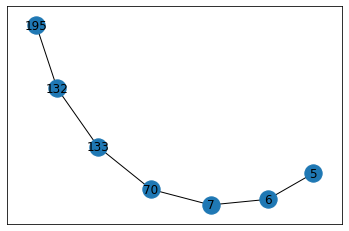

In [446]:
walk_graph = G50.subgraph(walk)
pos = nx.spring_layout(walk_graph, seed=42)
nx.draw_networkx(walk_graph, pos=pos, cmap='coolwarm')

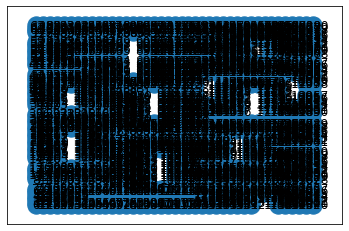

In [447]:
# pos50 = nx.spring_layout(G50, seed=42)
node_coords50 = np.argwhere(1-mz50[:,:,2])
nx.draw_networkx(G50, pos=node_coords50)

In [448]:
node_coords50

array([[ 1,  1],
       [ 1,  2],
       [ 1,  3],
       ...,
       [41, 76],
       [41, 77],
       [41, 78]])

In [464]:
subgraph_nodes = []
subgraph_coords = {}
for idx, pair in enumerate(node_coords50):
    if (pair[0] <= 5 and pair[1] <= 10):
        subgraph_nodes.append(idx)
        subgraph_coords[idx] = pair

In [465]:
subgraph_nodes

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259]

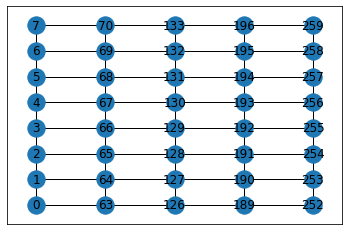

In [466]:
subgraph = G50.subgraph(subgraph_nodes)
nx.draw_networkx(subgraph, pos=subgraph_coords)

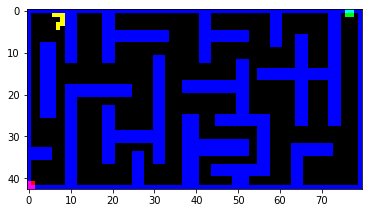

In [452]:
display(mz50,walk)

In [453]:
def augment_edge(G, walk_length):
    for start_node in G.nodes():
        walk = random_walk(G, start_node, walk_length)
        for end_node in walk:
            G.add_edge(start_node, end_node)

In [467]:
augment_edge(G50, 5)

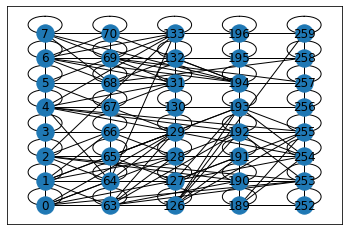

In [468]:
augmented_subgraph = G50.subgraph(subgraph_nodes)
nx.draw_networkx(augmented_subgraph, pos=subgraph_coords)

In [463]:
sp50, G50 = calc_shortest_path(mz50) # reset G50

2081 nodes.
3681 edges extracted 0.009553433999826666 s.
Graph created 0.009810399998968933 s.
source 1959 target 59
Shortest path with length 154 0.0025745889979589265 s.


In [525]:
degree_list = []
for node in G50.nodes():
    degree_list.append(G50.degree[node])

In [529]:
degree_list /= np.max(degree_list)

In [531]:
heatmap = np.zeros((43, 80))
for idx, coord in enumerate(node_coords50):
    heatmap[coord[0]][coord[1]] = degree_list[idx]

In [532]:
heatmap

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.42857143, 0.52380952, ..., 0.33333333, 0.42857143,
        0.        ],
       [0.        , 0.57142857, 0.61904762, ..., 0.42857143, 0.47619048,
        0.        ],
       ...,
       [0.        , 0.42857143, 0.57142857, ..., 0.57142857, 0.42857143,
        0.        ],
       [0.        , 0.33333333, 0.47619048, ..., 0.38095238, 0.33333333,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

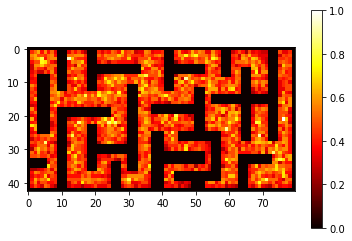

In [540]:
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

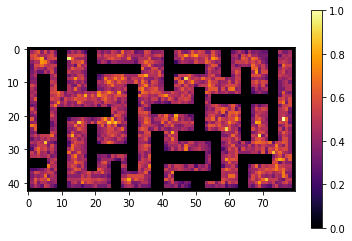

In [539]:
plt.imshow(heatmap, cmap='inferno', interpolation='nearest')
plt.colorbar()
plt.show()